# <p style="text-align:center;">**House selling prediction** - **Data Modeling**</p>

---

This source code aims to develop a model capable of **understanding patterns** and **generalizing labels** to predict whether a user will buy a house from a real estate website based on their profile.

In [513]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scikit_posthocs as sp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import randint, uniform
from sklearn.utils import resample

In [429]:
TEST_SIZE = 0.33
RANDOM_STATE = 42
LOWER_BOUND_CONFIDENCE_INTERVAL = 2.5
UPPER_BOUND_CONFIDENCE_INTERVAL = 97.5

stratified_cv = StratifiedKFold(n_splits=10, shuffle=True)

In [277]:
df_train, df_test = pd.read_csv('train.csv'), pd.read_csv('test.csv')

X_train, y_train = df_train.iloc[:, :-1].to_numpy(), df_train.iloc[:, -1].to_numpy()
X_test, y_test = df_test.iloc[:, :-1].to_numpy(), df_test.iloc[:, -1].to_numpy()

X_train[:5]

array([[2.10000000e+01, 7.00000000e+04, 0.00000000e+00, 2.09469273e+01,
        0.00000000e+00],
       [3.28008721e+01, 5.00000000e+04, 0.00000000e+00, 1.08428020e+01,
        0.00000000e+00],
       [2.70000000e+01, 3.00000000e+04, 0.00000000e+00, 2.67899432e+01,
        1.00000000e+00],
       [3.70000000e+01, 5.00000000e+04, 0.00000000e+00, 2.16227931e+01,
        0.00000000e+00],
       [5.00000000e+01, 1.00000000e+05, 1.00000000e+00, 2.32465077e+01,
        0.00000000e+00]])

In [355]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train[:5]

array([[-1.45287807,  0.36784019, -1.01503844,  0.52092279, -1.06159509],
       [-0.47361062, -0.44027093, -1.01503844, -0.91162954, -1.06159509],
       [-0.95498227, -1.24838204, -1.01503844,  1.34933948,  0.94197874],
       [-0.12515593, -0.44027093, -1.01503844,  0.61674634, -1.06159509],
       [ 0.95361831,  1.58000687,  0.98518437,  0.8469549 , -1.06159509]])

In [356]:
lr_model = LogisticRegression(max_iter=100000, class_weight='balanced')

param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga']
}

lr_grid = GridSearchCV(estimator=lr_model, 
                       param_grid=param_grid, 
                       cv=stratified_cv, 
                       scoring='roc_auc'
                      ).fit(X_train, y_train)

lr_grid.best_params_

{'C': 0.1, 'solver': 'liblinear'}

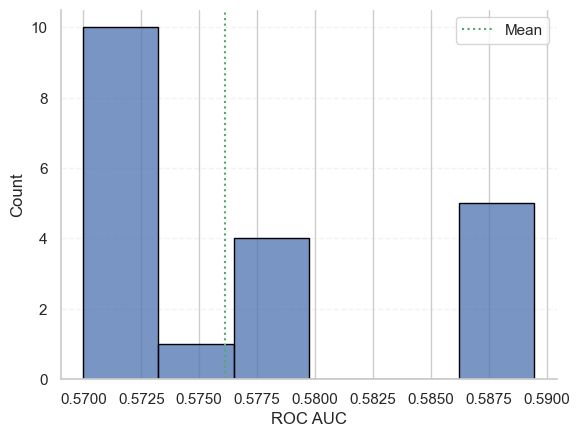

In [357]:
def hist_from_cv_auc(grid, bins=10):
    sns.histplot(grid.cv_results_['mean_test_score'], bins=bins, edgecolor='black', zorder=2)
    plt.axvline(np.mean(grid.cv_results_['mean_test_score']), c='g', linestyle=':', label='Mean')
    
    sns.despine()
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.25, zorder=1)
    plt.xlabel('ROC AUC')
    plt.ylabel('Count')
    plt.show()

hist_from_cv_auc(lr_grid, bins=6)

In [501]:
def plot_roc_curves(train_true, train_scores, test_true, test_scores):
    train_fpr, train_tpr, _ = roc_curve(train_true, train_scores)
    test_fpr, test_tpr, _ = roc_curve(test_true, test_scores)
    
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC (AUC = {train_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('ROC Curve - Train', fontsize=14)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(linestyle='--', alpha=0.5)
    sns.despine()

    plt.subplot(1, 2, 2)
    plt.plot(test_fpr, test_tpr, color='green', lw=2, label=f'Test ROC (AUC = {test_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('ROC Curve - Test', fontsize=14)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(linestyle='--', alpha=0.5)
    sns.despine()
    
    plt.tight_layout()
    plt.show()

In [507]:
lr_best = lr_grid.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, lr_best.predict(X_train)):.2f}
Test ROC AUC: {roc_auc_score(y_test, lr_best.predict(X_test)):.2f}""")

Train ROC AUC: 0.62
Test ROC AUC: 0.51


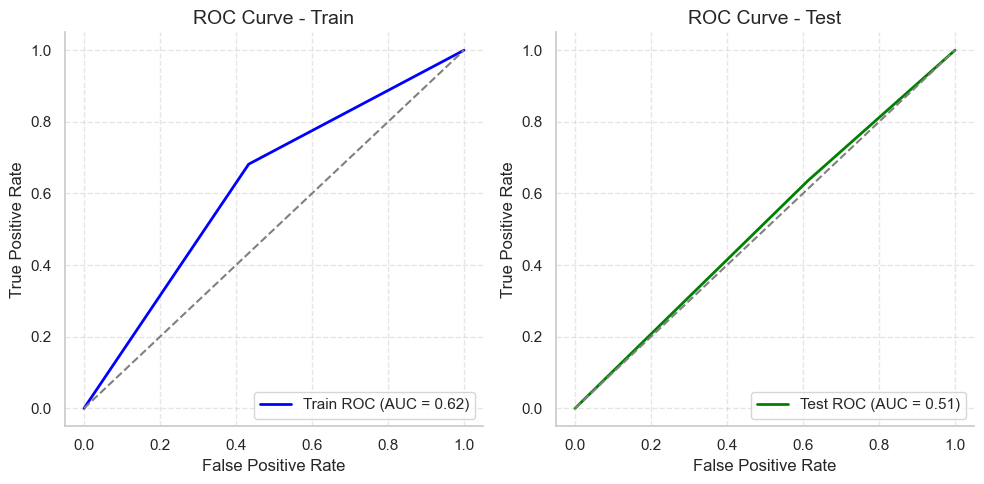

In [502]:
plot_roc_curves(y_train, lr_best.predict(X_train), y_test, lr_best.predict(X_test))

In [359]:
print(classification_report(y_train, lr_best.predict(X_train)))
print(classification_report(y_test, lr_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        90
           1       0.43      0.68      0.53        44

    accuracy                           0.60       134
   macro avg       0.61      0.62      0.59       134
weighted avg       0.67      0.60      0.62       134

              precision    recall  f1-score   support

           0       0.68      0.39      0.49        44
           1       0.34      0.64      0.44        22

    accuracy                           0.47        66
   macro avg       0.51      0.51      0.47        66
weighted avg       0.57      0.47      0.48        66



In [360]:
def show_importances(data):
    df = (
        pd.DataFrame(
            data={'Importance': data.flatten()},
            index=df_train.iloc[:, :-1].columns
        )
        .sort_values(by='Importance', ascending=True)
    )
    
    plt.figure(figsize=(8, 6))
    df.plot(
        kind='barh',
        zorder=2,
        legend=False,
        alpha=0.8,
        color=sns.color_palette('viridis', len(df))
    )
    
    sns.despine(left=True)
    plt.grid(axis='x', zorder=1, linestyle='--', alpha=0.5)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Feature Importance', fontsize=14, pad=15)
    
    plt.tight_layout()
    plt.show()

<Figure size 800x600 with 0 Axes>

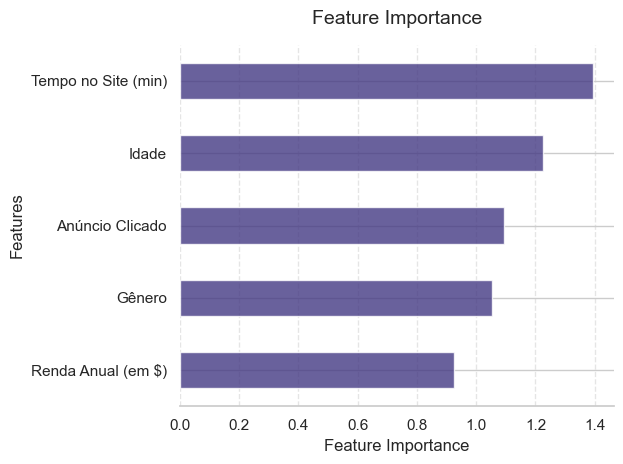

In [361]:
show_importances(np.exp(lr_best.coef_))

In [129]:
def get_auc_score_n_degree(n):
    poly = PolynomialFeatures(degree=n)
    
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    lr_model_poly = LogisticRegression(max_iter=1000000, class_weight='balanced', C=0.1)
    
    lr_model_poly.fit(X_train_poly, y_train)
    
    return (roc_auc_score(y_train, lr_model_poly.predict(X_train_poly)), roc_auc_score(y_test, lr_model_poly.predict(X_test_poly)))

In [363]:
lr_auc_scores = {degree:get_auc_score_n_degree(degree) for degree in range(1, 15)}

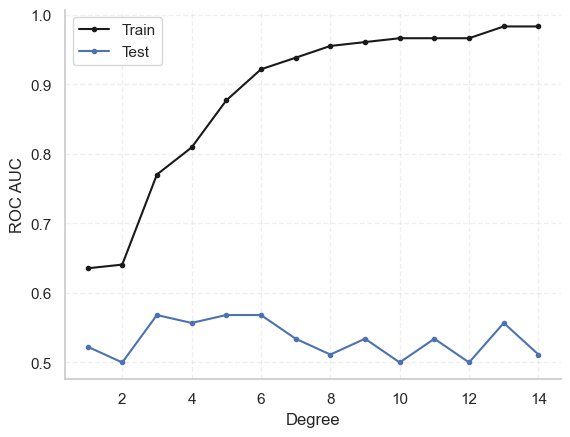

Max train ROC AUC: 0.9830808080808081
Max test ROC AUC: 0.5681818181818182


In [364]:
plt.plot(lr_auc_scores.keys(), [i for i, j in lr_auc_scores.values()], marker='.', c='k', label='Train')
plt.plot(lr_auc_scores.keys(), [j for i, j in lr_auc_scores.values()], marker='.', c='b', label='Test')

sns.despine()
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.xlabel('Degree')
plt.ylabel('ROC AUC')
plt.show()

print(f"""Max train ROC AUC: {max(i for i, j in lr_auc_scores.values())}
Max test ROC AUC: {max(j for i, j in lr_auc_scores.values())}""")

In [436]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf_grid = GridSearchCV(estimator=rf_model, 
                       param_grid=param_grid, 
                       cv=stratified_cv, 
                       scoring='roc_auc',
                       n_jobs=2
                      ).fit(X_train, y_train)

rf_grid.best_params_

{'criterion': 'gini', 'n_estimators': 100}

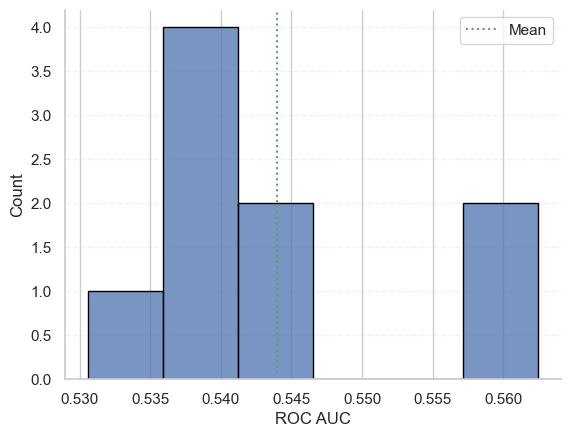

In [437]:
hist_from_cv_auc(rf_grid, bins=6)

In [508]:
rf_best = rf_grid.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, rf_best.predict(X_train)):.2f}
Test ROC AUC: {roc_auc_score(y_test, rf_best.predict(X_test)):.2f}""")

Train ROC AUC: 1.00
Test ROC AUC: 0.58


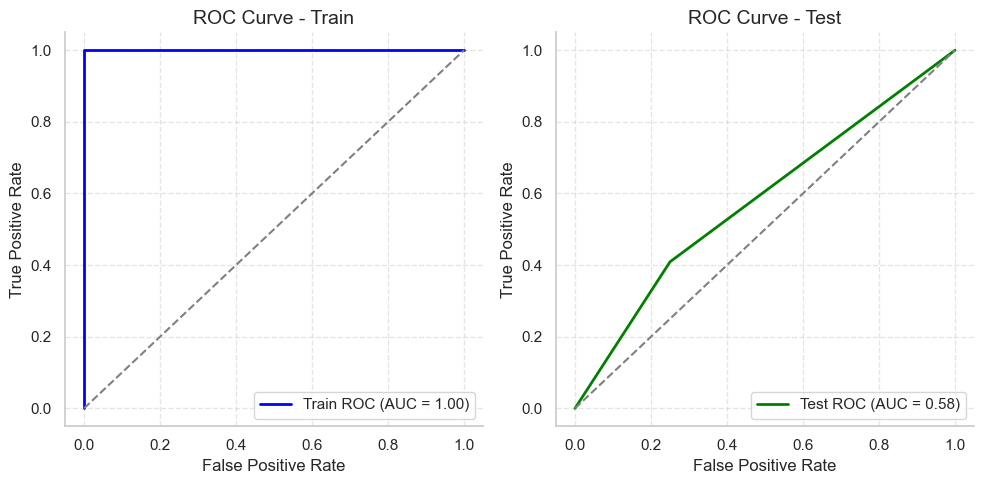

In [503]:
plot_roc_curves(y_train, rf_best.predict(X_train), y_test, rf_best.predict(X_test))

In [442]:
print(classification_report(y_train, rf_best.predict(X_train)))
print(classification_report(y_test, rf_best.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        44

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        44
           1       0.45      0.41      0.43        22

    accuracy                           0.64        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.63      0.64      0.63        66



In [368]:
param_grid = {
    'n_estimators': [50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 5],
    'max_leaf_nodes': [3, 5, 10, 15]
}

rf_grid_regu = GridSearchCV(estimator=rf_model, 
                       param_grid=param_grid, 
                       cv=stratified_cv, 
                       scoring='roc_auc',
                       n_jobs=2
                      ).fit(X_train, y_train)

rf_grid_regu.best_params_

{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 100}

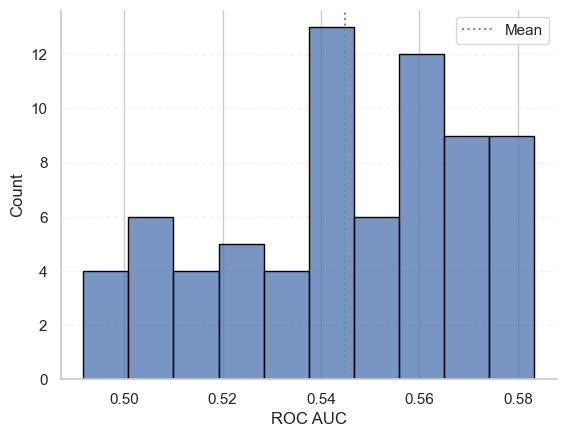

In [369]:
hist_from_cv_auc(rf_grid_regu)

In [509]:
rf_regu_best = rf_grid_regu.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, rf_regu_best.predict(X_train)):.2f}
Test ROC AUC: {roc_auc_score(y_test, rf_regu_best.predict(X_test)):.2f}""")

Train ROC AUC: 0.73
Test ROC AUC: 0.53


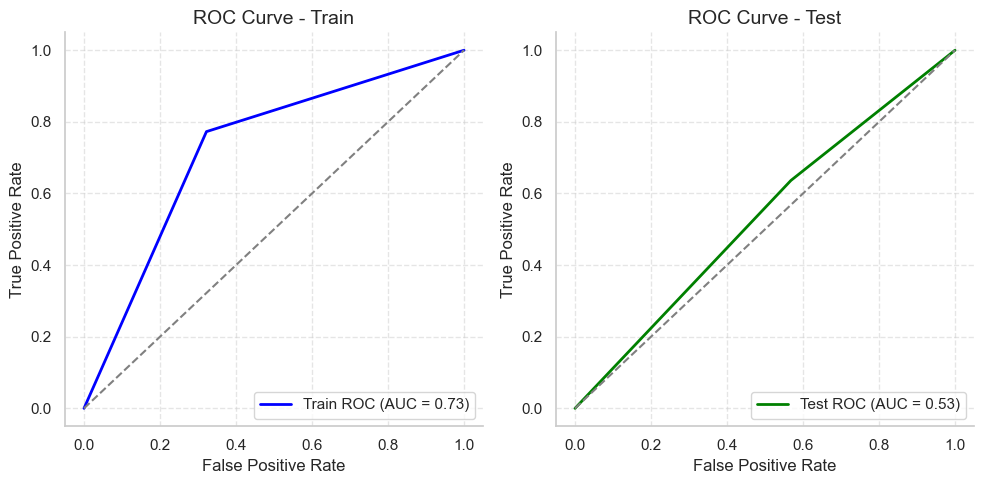

In [504]:
plot_roc_curves(y_train, rf_regu_best.predict(X_train), y_test, rf_regu_best.predict(X_test))

In [443]:
print(classification_report(y_train, rf_regu_best.predict(X_train)))
print(classification_report(y_test, rf_regu_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76        90
           1       0.54      0.77      0.64        44

    accuracy                           0.71       134
   macro avg       0.70      0.73      0.70       134
weighted avg       0.75      0.71      0.72       134

              precision    recall  f1-score   support

           0       0.70      0.43      0.54        44
           1       0.36      0.64      0.46        22

    accuracy                           0.50        66
   macro avg       0.53      0.53      0.50        66
weighted avg       0.59      0.50      0.51        66



<Figure size 800x600 with 0 Axes>

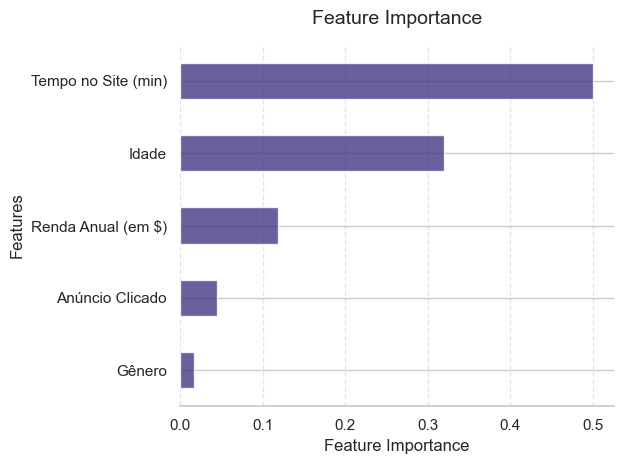

In [444]:
show_importances(rf_regu_best.feature_importances_)

In [393]:
param_dist = {'n_estimators': randint(50,300),
              'max_depth': randint(2, 6),
              'max_leaf_nodes': randint(2, 6),
              'criterion': ['gini', 'entropy', 'log_loss']}

rf_random = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

rf_random_grid = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=param_dist,
    cv=stratified_cv,
    scoring='roc_auc',
    n_iter=30,
    n_jobs=2,
    random_state=RANDOM_STATE
).fit(X_train, y_train)

rf_random_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 2,
 'n_estimators': 109}

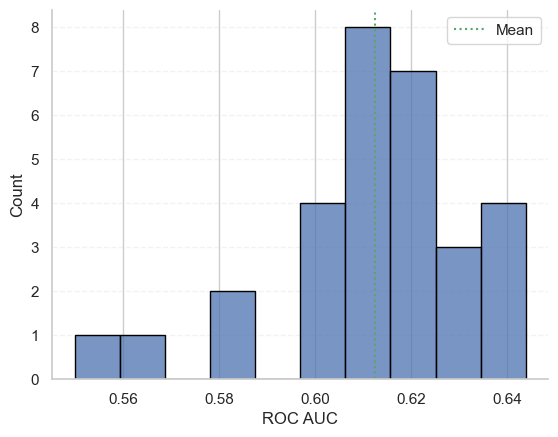

In [394]:
hist_from_cv_auc(rf_random_grid)

In [396]:
rf_random_best = rf_random_grid.best_estimator_.fit(X_train, y_train)

print(f"""Train ROC AUC: {roc_auc_score(y_train, rf_random_best.predict(X_train))}
Test ROC AUC: {roc_auc_score(y_test, rf_random_best.predict(X_test))}""")

Train ROC AUC: 0.6636363636363637
Test ROC AUC: 0.5113636363636364


In [441]:
def get_bootstrap_confidences(model, X_test, y_test, iterations=10000):
    accuracies, baseline_accuracy = [], roc_auc_score(y_test, model.predict(X_test))

    for _ in range(iterations):
        X_test_resample, y_test_resample = resample(X_test, y_test)

        y_pred_resampled = model.predict(X_test_resample)

        acc = roc_auc_score(y_test_resample, y_pred_resampled)
        accuracies.append(acc)

    bootstrap_mean = np.mean(accuracies)
    bootstrap_std_error = np.std(accuracies, ddof=1)

    print(f"Bootstrap mean: {bootstrap_mean:.4f}")
    print(f"Standard error: {bootstrap_std_error:.4f}")

    lower_bound = np.percentile(accuracies, LOWER_BOUND_CONFIDENCE_INTERVAL)
    upper_bound = np.percentile(accuracies, UPPER_BOUND_CONFIDENCE_INTERVAL)
    
    print(f"Confidence interval (95%): [{lower_bound:.4f}, {upper_bound:.4f}]")

    plt.hist(accuracies, bins=30, alpha=0.7, color='blue')
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper bound')
    plt.axvline(baseline_accuracy, color='black', linestyle='-', label='Baseline accuracy')
    plt.legend()
    sns.despine()
    plt.grid(linestyle='--', alpha=0.4)
    plt.show()

Bootstrap mean: 0.5109
Standard error: 0.0631
Confidence interval (95%): [0.3864, 0.6359]


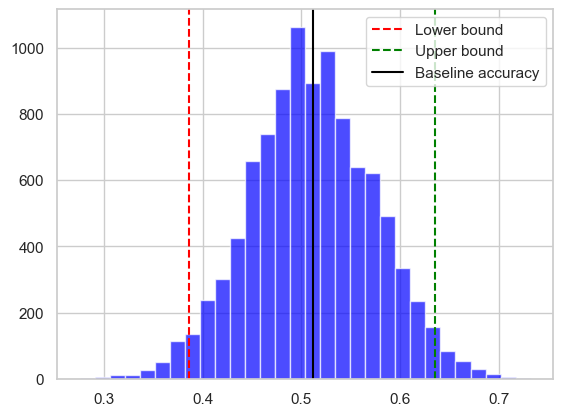

In [432]:
get_bootstrap_confidences(lr_best, X_test, y_test)

Bootstrap mean: 0.5788
Standard error: 0.0622
Confidence interval (95%): [0.4583, 0.7014]


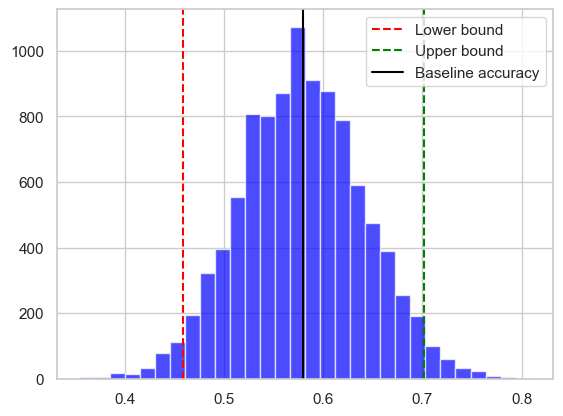

In [439]:
get_bootstrap_confidences(rf_best, X_test, y_test)

Bootstrap mean: 0.5342
Standard error: 0.0644
Confidence interval (95%): [0.4076, 0.6587]


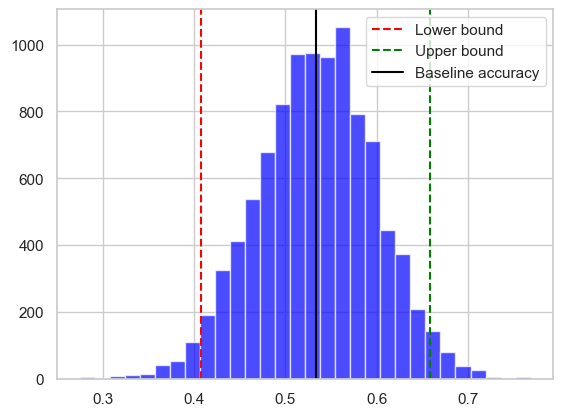

In [440]:
get_bootstrap_confidences(rf_regu_best, X_test, y_test)

In [514]:
scores_lr = cross_val_score(lr_best, X_test, y_test, scoring='roc_auc', cv=stratified_cv)
scores_rf = cross_val_score(rf_best, X_test, y_test, scoring='roc_auc', cv=stratified_cv)
scores_rf_regu = cross_val_score(rf_regu_best, X_test, y_test, scoring='roc_auc', cv=stratified_cv)

scores = np.array([scores_lr, scores_rf, scores_rf_regu]).T 

nemenyi_results = sp.posthoc_nemenyi_friedman(scores)

print(nemenyi_results)

          0         1         2
0  1.000000  0.502897  0.643827
1  0.502897  1.000000  0.972813
2  0.643827  0.972813  1.000000


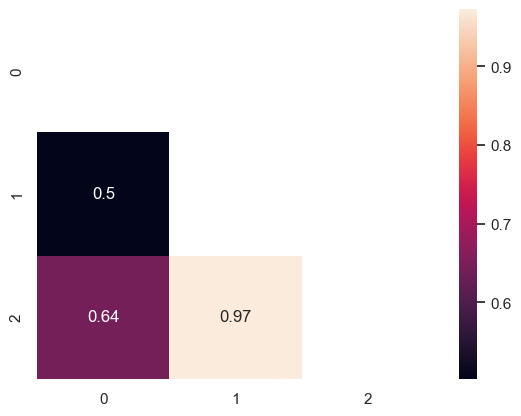

In [516]:
sns.heatmap(nemenyi_results, annot=True, mask=np.triu(nemenyi_results))

"""
0: Logistic Regression
1: Random Forest
2: Random Forest Regularized
"""

plt.grid(False)
plt.show()